In [22]:
import sys
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time

In [23]:

class NN:

    def __init__(self, n_input = 784, n_hidden = 30, n_out = 10, epoch = 30, mini_b = 20, l_rate = 3):
        #set up initials 
        self.feature_train = []
        self.feature_test = []
        self.target_train = []
        self.target_test = []

        self.N_input = n_input
        self.N_hidden = n_hidden
        self.N_out = n_out
        
        self.epoch = epoch 
        self.minibatch = mini_b
        self.l_rate = l_rate
        self.layers = 3

        self.parameters = self.get_parameters()
        self.count = 0


    def arrange_data(self, train_file, test_file):
        #open files 
        train_set = self.open_data(train_file)
        test_set = self.open_data(test_file)
        #split label and pixels 
        self.target_train, self.feature_train = self.split_data(train_set)
        self.target_test, self.feature_test = self.split_data(test_set)

    def split_data(self, data):
        #seperates a data set into the targets and features
        label_set = data["label"]
        target_set = [] 
        
        for row in label_set:
            new_row = self.to_matrix_form(row)
            target_set.append(new_row)   

        df = pd.DataFrame(data)
        #changed format to aid in calc
        feature_set = (df.drop('label', axis=1)/255).astype('float32')

        return np.array(target_set), np.array(feature_set)

    def to_matrix_form(self, val, size = 10):
        #
        arr = np.zeros(size, dtype='float32')
        arr[val] = 1.

        return arr

    def open_data(self, file):
        data_set = pd.read_csv(file)
        return data_set

    def get_parameters(self):

        parameters = {
            'W1': np.random.normal(0.0, 1.0, (self.N_hidden, self.N_input)),
            'W2': np.random.normal(0.0, 1.0, (self.N_out, self.N_hidden)),

            'B1': np.random.normal(0.0, 1.0, (self.N_hidden, 1)),
            'B2': np.random.normal(0.0, 1.0, (self.N_out, 1)),
            
            }       

        return parameters

    def forward(self, feature_train):

        parameters = self.parameters
        parameters['A0'] = feature_train

        #input layer to hidden layer    
        hidden = np.dot(parameters['W1'], parameters['A0'])
        hidden = np.reshape(hidden, (30,1))
        parameters['Z1'] = parameters['B1'] + hidden
        parameters['A1'] = self.sigmoid(parameters['Z1'])


        #hidden layer to the output layer
        parameters['Z2'] = np.dot(parameters['W2'], parameters['Z1']) + parameters['B2']
        parameters['A2'] = self.sigmoid(parameters['Z2'])

        return parameters['A2']

    def backprop(self, feature, output):

        parameters = self.parameters
        feature = np.reshape(feature, (10,1))
        error_o = output - feature

        self.parameters['W2'] += -self.l_rate * np.dot(error_o, parameters['A1'].T)
        self.parameters['B2'] += -self.l_rate * error_o 

        error_h = np.dot(self.parameters['W2'].T, error_o) * self.sigmoid(parameters['A1'], True)
        
        item = np.reshape(parameters['A0'], (784,1))

        self.parameters['W1'] += -self.l_rate * np.dot(error_h, item.T)
        self.parameters['B1'] += -self.l_rate * error_h

    def sigmoid(self, z, deriv = False):
        if deriv:
            return (np.exp(-z))/((np.exp(-z)+1)**2)
        return 1.0 / (1.0 + np.exp(-z))

    def batch_parameters(self, batch_size, set_size):
        
        last_batch = False
        idx_a = self.count * batch_size
        idx_b = (self.count + 1) * batch_size
        self.count += 1
        if idx_b >= set_size:
            idx_b = set_size
            last_batch = True

        return idx_a, idx_b, last_batch

    def plot_accuracy(self, accuracy):
        #plt.figure(dpi=125)
        plt.plot(accuracy)
        plt.title("Accuracy vs Epochs")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')

    def train_net(self, feat_train, target_train, feat_test, target_test, mini_batch):
        acc_list = []
        for i in range(self.epoch):
            start = time.time()
            #randomly shuffling the train dataset
            sets = list(zip(feat_train, target_train))
            np.random.shuffle(sets)
            feat_train, target_train = zip(*sets)
            
            self.count = 0
            last_batch = False
            #loop until the last batch is happening
            while(1):
                
                #get the next batch indexs of the dataset and the bool -> if its the last batch 
                idx_a, idx_b, last_batch = self.batch_parameters(mini_batch, len(feat_train))

                mini_feat_train = feat_train[idx_a:idx_b]
                mini_target_train = target_train[idx_a:idx_b]

                #loop for the mini training sets
                for j in range(len(mini_feat_train)):
                    output = self.forward(mini_feat_train[j])
                    self.backprop(mini_target_train[j], output)
                
                if last_batch:
                    break
            
            #testing the test set on the trained neural net for each epoch 
            accuracy = self.test_net(feat_test, target_test)
            print('Epoch: {0}, Accuracy: {1}'.format(i+1, accuracy))
            #collected for total accuracy 
            acc_list.append(float(accuracy))
            end = time.time()
            print("  Time: " + str(end - start))

        self.plot_accuracy(acc_list)
        print("Maximum Accuracy Achives: ", end="")
        print((max(acc_list)))

    #handles the testing of the neural netowrk  
    def test_net(self, f_test, t_test):
        predictions = []

        for i in range(len(f_test)):
            output = self.forward(f_test[i])
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(t_test[i]))

        return np.mean(predictions)

    def driver(self, train_file, test_file):
        self.arrange_data(train_file, test_file)
        self.train_net(self.feature_train, self.target_train, self.feature_test, self.target_test, self.minibatch)


/var/folders/9h/5rdtpgfj3bq22jzkcfbn5rwh0000gn/T/ipykernel_79929/2264643403.py:107: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


Epoch: 1, Accuracy: 0.7812
  Time: 5.304368734359741
Epoch: 2, Accuracy: 0.7432
  Time: 5.388261795043945
Epoch: 3, Accuracy: 0.6222
  Time: 5.1641600131988525
Epoch: 4, Accuracy: 0.6773
  Time: 4.894629955291748
Epoch: 5, Accuracy: 0.7797
  Time: 6.384258985519409
Epoch: 6, Accuracy: 0.6341
  Time: 6.6905810832977295
Epoch: 7, Accuracy: 0.7423
  Time: 6.526677131652832
Epoch: 8, Accuracy: 0.7616
  Time: 5.7791588306427
Epoch: 9, Accuracy: 0.6589
  Time: 6.141541957855225
Epoch: 10, Accuracy: 0.6717
  Time: 5.652342081069946
Epoch: 11, Accuracy: 0.755
  Time: 5.781973838806152
Epoch: 12, Accuracy: 0.707
  Time: 5.899662017822266
Epoch: 13, Accuracy: 0.6859
  Time: 6.019296884536743
Epoch: 14, Accuracy: 0.7927
  Time: 6.069900035858154
Epoch: 15, Accuracy: 0.7491
  Time: 6.253048896789551
Epoch: 16, Accuracy: 0.6914
  Time: 6.389035940170288
Epoch: 17, Accuracy: 0.7052
  Time: 7.049460172653198
Epoch: 18, Accuracy: 0.6556
  Time: 6.292335033416748
Epoch: 19, Accuracy: 0.7185
  Time: 6.2

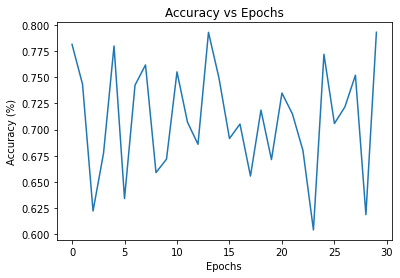

In [24]:

if __name__ == "__main__":
    
    ####################### USER SETUP AREA ####################### 

    n_input = 784
    n_hidden = 30
    n_out = 10

    #training
    epoch = 30
    mini_b = 20
    l_rate = 0.03
        
    ####################### END OF USER SETUP #######################

    nn = NN(n_input, n_hidden, n_out, epoch, mini_b, l_rate)
    start = time.time()
    nn.driver("fashion-mnist_train.csv.gz", "fashion-mnist_test.csv.gz")
    end = time.time()
    print("Total Time: ", end="")
    print(end - start)
